In [1]:
import json
import pandas as pd
import re

import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
def jsonReader(path):
    with open(path, "r") as json_file:
        data = json.load(json_file)
    return data

In [3]:
def clean_text(text):
    text = re.sub(r"[\"\\]", "", text)  #
    text = re.sub(r"\s+", " ", text)   
    text = text.strip()                
    return text

In [4]:
r1 = jsonReader("models/llmModels/llmResponses/gpt.json")
r2 = jsonReader("models/llmModels/llmResponses/llama.json")
r3 = jsonReader("models/llmModels/llmResponses/qwen.json")

In [5]:
llmResponses = pd.DataFrame(data=[r1,r2,r3])
llmResponses["response"] = llmResponses["response"].apply(clean_text)
llmResponses.head()

,model,response
0,gpt,"Overall, user sentiment regarding the dress is..."
1,llama,Overall sentiment: The user reviews for the dr...
2,qwen,The analysis of the given text indicates that ...


rouge

In [6]:
from rouge_score import rouge_scorer

def evaluate_rouge(reference,prediction):
    scorer = rouge_scorer.RougeScorer(["rouge1", "rougeL"], use_stemmer=True)
    scores = scorer.score(reference, prediction)
    return scores

In [7]:
rougeData = list()
for r,rrow in llmResponses.iterrows():
    refName = rrow["model"]
    refResponse = rrow["response"]

    for p,prow in llmResponses.iterrows():
        preName = prow["model"]
        preResponse = prow["response"]

        scores = evaluate_rouge(refResponse,preResponse)

        rougeData.append({
            "ref":refName,
            "pre":preName,
            "rouge1-f1":scores["rouge1"].fmeasure,
            "rougeL-f1":scores["rougeL"].fmeasure
        })

rougeDF = pd.DataFrame(data=rougeData)



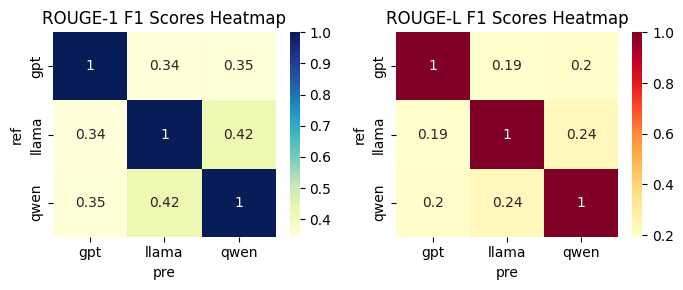

In [8]:
pivot_rouge1 = rougeDF.pivot(index="ref", columns="pre", values="rouge1-f1")
pivot_rougeL = rougeDF.pivot(index="ref", columns="pre", values="rougeL-f1")

fig, axs = plt.subplots(1, 2, figsize=(7, 3))

sns.heatmap(pivot_rouge1, annot=True, cmap="YlGnBu", cbar=True, ax=axs[0])
axs[0].set_title("ROUGE-1 F1 Scores Heatmap")

sns.heatmap(pivot_rougeL, annot=True, cmap="YlOrRd", cbar=True, ax=axs[1])
axs[1].set_title("ROUGE-L F1 Scores Heatmap")

plt.tight_layout()
plt.show()

bleu

In [9]:
from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction
smoothing = SmoothingFunction()
def evaluate_bleu(reference,prediction):
    reference_tokens = reference.split()
    prediction_tokens = prediction.split()
    return sentence_bleu([reference_tokens], prediction_tokens, smoothing_function=smoothing.method1)

In [10]:
bleuData = list()
for r,rrow in llmResponses.iterrows():
    refName = rrow["model"]
    refResponse = rrow["response"]

    for p,prow in llmResponses.iterrows():
        preName = prow["model"]
        preResponse = prow["response"]

        score = evaluate_bleu(refResponse,preResponse)

        bleuData.append({
            "ref":refName,
            "pre":preName,
            "bleu":score
        })

bleuDF = pd.DataFrame(data=bleuData)



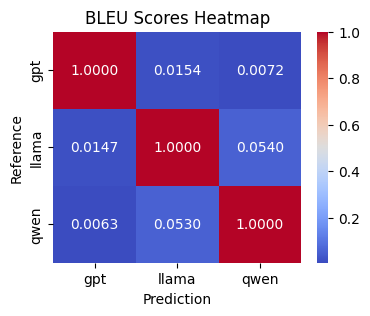

In [11]:
pivot_bleu = bleuDF.pivot(index="ref", columns="pre", values="bleu")
plt.figure(figsize=(4, 3))
sns.heatmap(
    pivot_bleu, annot=True, fmt=".4f", cmap="coolwarm", cbar=True
)
plt.title("BLEU Scores Heatmap")
plt.ylabel("Reference")
plt.xlabel("Prediction")
plt.show()

cos

In [12]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity

def evaluate_cosine_similarity(reference,prediction):
    vectorizer = TfidfVectorizer()
    tfidf_matrix = vectorizer.fit_transform([prediction, reference])
    cosine_sim = cosine_similarity(tfidf_matrix[0:1], tfidf_matrix[1:2])
    return cosine_sim[0][0]

In [13]:
cosData = list()
for r,rrow in llmResponses.iterrows():
    refName = rrow["model"]
    refResponse = rrow["response"]

    for p,prow in llmResponses.iterrows():
        preName = prow["model"]
        preResponse = prow["response"]

        cos = evaluate_cosine_similarity(refResponse,preResponse)

        cosData.append({
            "ref":refName,
            "pre":preName,
            "cos":cos
        })

cosDF = pd.DataFrame(data=cosData)


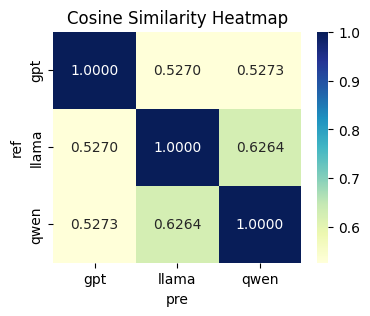

In [14]:
pivot_cos = cosDF.pivot(index="ref", columns="pre", values="cos")
fig, ax = plt.subplots(figsize=(4, 3))
sns.heatmap(pivot_cos, annot=True, fmt=".4f", cmap="YlGnBu", cbar=True, ax=ax)
ax.set_title("Cosine Similarity Heatmap")

plt.show()